# Task analysis
1. Overall this is a text matching task
2. Need an indicator to measure whether question 1 and question 2 are similar
3. Unstructured data(text) is stored in structured tables

In [1]:
import torch
import torch.nn as nn
import numpy as np
import re
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
transformers.logging.set_verbosity_error()

In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:

SEED = 1024

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Data Analysis

In [4]:

train_df = pd.read_csv("../input/quora-questions-pair/Quora.csv")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

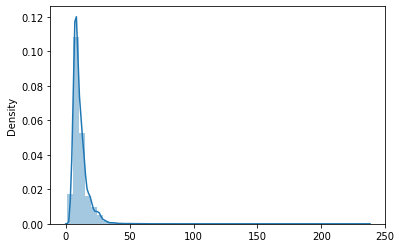

In [5]:

train_df.dropna(inplace=True)
train_sentences_lens = train_df['question1'].apply(lambda x: len(x.split(' '))).tolist()
train_sentences_lens.extend(train_df['question2'].apply(lambda x: len(x.split(' '))).tolist())
sns.distplot(train_sentences_lens)

In [6]:

MAX_LEN = 40

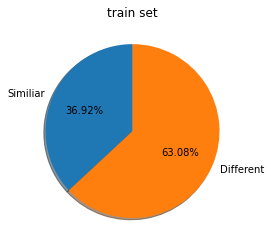

In [7]:

def pie_chart(similar_questions_num, different_questions_num, set_type):
    labels = 'Similiar', 'Different'
    sizes = [similar_questions_num, different_questions_num]

    fig1, ax1 = plt.subplots()
    ax1.set_title(set_type)
    ax1.pie(sizes, labels=labels, autopct='%1.2f%%', shadow=True, startangle=90)

    plt.show()

similar_samples_num = sum(train_df['is_duplicate'].values)
pie_chart(similar_samples_num, len(train_df['is_duplicate']) - similar_samples_num, 'train set')

In [8]:

qids = pd.Series(list(train_df['qid1']) + list(train_df['qid2']))

print ('Unique Questions number: {}\n'.format(len(np.unique(qids))))

q_vals=qids.value_counts()[0:5]
print ('Top 5 most frequently asked questions: ')

for pair in q_vals.iteritems():
    print(train_df.loc[train_df['qid2']==pair[0]]['question1'].head(1).values + " count: " + str(pair[1]))

q_vals=q_vals.values

Unique Questions number: 537929

Top 5 most frequently asked questions: 
['Why do I not lose weight when I throw up? count: 157']
['If I link my Instagram account to my Facebook account, will my friends from Facebook be able to see the photos I post even if my Instagram account is private? count: 120']
['What are some ways to lose 25 pounds in one month? count: 111']
['How can I make money online in India? count: 88']
['How do I make money using Instagram? count: 79']


In [9]:

duplicate_rows = train_df[train_df.duplicated(['qid1','qid2'])]
print ("Number of duplicate questions : ", len(duplicate_rows))

Number of duplicate questions :  0


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


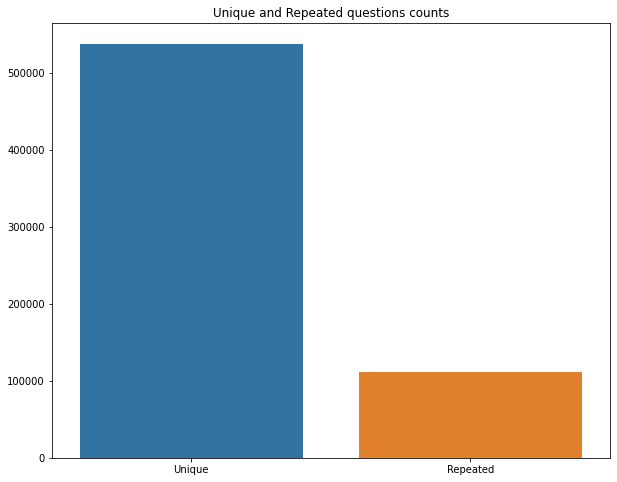

In [10]:

x = ["Unique" , "Repeated"]
y =  [len(np.unique(qids)), np.sum(qids.value_counts() > 1)]

plt.figure(figsize=(10, 8))
plt.title ("Unique and Repeated questions counts")
sns.barplot(x,y)
plt.show()


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


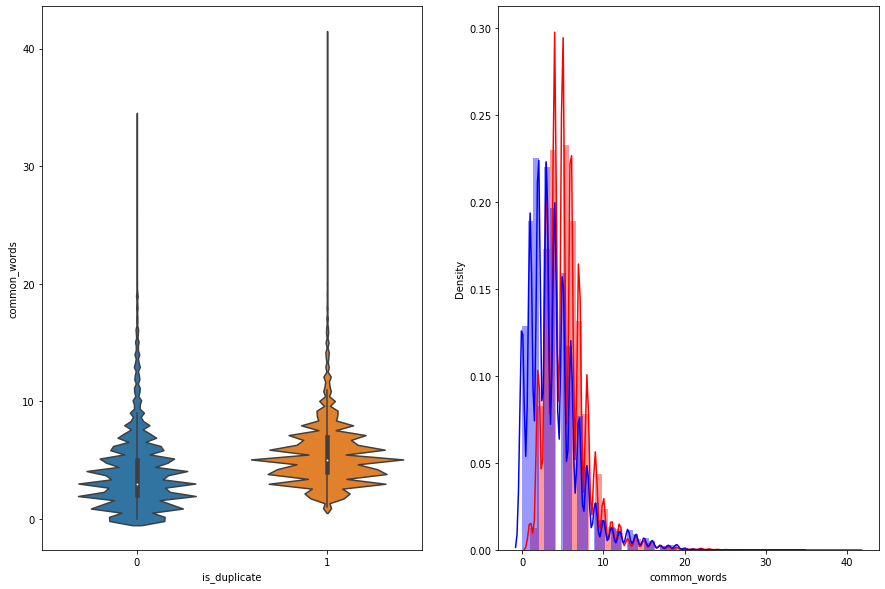

In [11]:

def common_words(row):
    q1_word_set = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    q2_word_set = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(q1_word_set & q2_word_set)

train_df['common_words'] = train_df.apply(common_words, axis=1)
plt.figure(figsize=(15, 10))

plt.subplot(1,2,2)
sns.distplot(train_df[train_df['is_duplicate'] == 1]['common_words'][0:] , label = "1", color = 'red')
sns.distplot(train_df[train_df['is_duplicate'] == 0]['common_words'][0:] , label = "0" , color = 'blue' )

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'common_words', data = train_df[0:])

plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


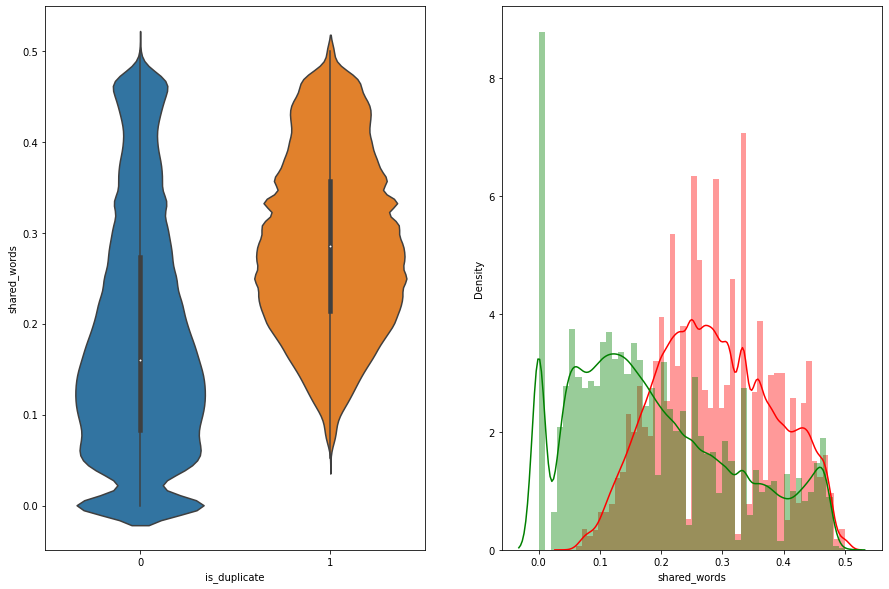

In [12]:

def shared_words(row):
    q1_word_set = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    q2_word_set = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(q1_word_set & q2_word_set) / (len(q1_word_set) + len(q2_word_set))    

train_df['shared_words'] = train_df.apply(shared_words, axis=1)
plt.figure(figsize=(15, 10))

plt.subplot(1,2,2)
sns.distplot(train_df[train_df['is_duplicate'] == 1]['shared_words'][0:] , label = "1", color = 'red')
sns.distplot(train_df[train_df['is_duplicate'] == 0]['shared_words'][0:] , label = "0" , color = 'green' )

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'shared_words', data = train_df[0:])

plt.show()

# Data Cleaning

In [13]:
def text_clean(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

   

    return text

In [14]:
train_df['cleaned_question1']=train_df['question1'].apply(lambda x:text_clean(x))
train_df['cleaned_question2']=train_df['question2'].apply(lambda x:text_clean(x))

In [15]:
len(train_df)
train_df['len_q1']=train_df['cleaned_question1'].apply(lambda x:len(x.split()))  # split by white space and count number of words in question1 per each row
train_df['len_q2']=train_df['cleaned_question2'].apply(lambda x:len(x.split()))  # split by white space and count number of words in question2 per each row

In [16]:
train_df

,id,qid1,qid2,question1,question2,is_duplicate,common_words,shared_words,cleaned_question1,cleaned_question2,len_q1,len_q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,10.0,0.434783,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,14,12
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4.0,0.200000,what is the story of kohinoor koh - i - noor d...,what would happen if the indian government sto...,12,17
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,4.0,0.166667,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,14,10
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.0,0.000000,why am i mentally very lonely how can i solve it,find the remainder when math 23 ^ 24 math is d...,11,14
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,2.0,0.100000,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,13,7
...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,11.0,0.440000,how many keywords are there in the racket prog...,how many keywords are there in perl programmin...,14,13
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1,5.0,0.312500,do you believe there is life after death,is it true that there is life after death,8,9
404287,404287,537928,537929,What is one coin?,What's this coin?,0,1.0,0.142857,what is one coin,what is this coin,4,4
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,1.0,0.025000,what is the approx annual cost of living while...,i am having little hairfall problem but i want...,17,25


# Define a Bert model and read data into the model

In [17]:

BERT_VERSION = 'bert-base-uncased'
POOLED_OUTPUT_DIM = 768 
tokenizer = BertTokenizer.from_pretrained(BERT_VERSION)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [18]:

train_df, val_df = train_test_split(train_df, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [19]:

class BertDataSet:
    def __init__(self, first_questions, second_questions, targets, tokenizer):
        self.first_questions = first_questions
        self.second_questions = second_questions
        self.targets = targets
        self.tokenizer = tokenizer
        self.length = len(first_questions)
        
    def __len__(self):
        return self.length

    def __getitem__(self, item):
        first_question = str(self.first_questions[item])
        second_question = str(self.second_questions[item])

        
        first_question = " ".join(first_question.split())
        second_question = " ".join(second_question.split())
        
      
        inputs = self.tokenizer.encode_plus(
            first_question,
            second_question,
            add_special_tokens=True,
            padding='max_length',
            max_length=2 * MAX_LEN + 3, # max length of 2 questions and 3 special tokens
            truncation=True   
        )
   
        return {
            "ids": torch.tensor(inputs["input_ids"], dtype=torch.long),
            "mask": torch.tensor(inputs["attention_mask"], dtype=torch.long),
            "token_type_ids": torch.tensor(inputs["token_type_ids"], dtype=torch.long),
            "targets": torch.tensor(int(self.targets[item]), dtype=torch.long) if self.targets is not None else 0
        }

In [20]:

def get_data_loader(df, targets, batch_size, shuffle, tokenizer):
    dataset = BertDataSet(
        first_questions=df["cleaned_question1"].values,
        second_questions=df["cleaned_question2"].values,
        targets=targets,
        tokenizer=tokenizer
    )
    
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle=shuffle
    )
    
    return data_loader

In [21]:
BS = 128

In [22]:

train_data_loader = get_data_loader(
    df=train_df,
    targets=train_df["is_duplicate"].values,
    batch_size=BS,
    shuffle=True,
    tokenizer=tokenizer
)

val_data_loader = get_data_loader(
    df=val_df,
    targets=val_df["is_duplicate"].values,
    batch_size=4 * BS,
    shuffle=True,
    tokenizer=tokenizer
)

In [23]:

class BertModel(nn.Module):
    def __init__(self, bert_path):
        super(BertModel, self).__init__()
        self.bert_path = bert_path
        self.bert = transformers.BertModel.from_pretrained(self.bert_path)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(POOLED_OUTPUT_DIM, 1)

    def forward(self, ids, mask, token_type_ids):
        _, pooled = self.bert(ids, attention_mask=mask,token_type_ids=token_type_ids,return_dict=False)
        
        # add dropout to prevent overfitting.
        pooled = self.dropout(pooled) 
        return self.out(pooled)


model = BertModel(BERT_VERSION).to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

In [24]:

def loss_fn(outputs, targets):
    outputs = torch.squeeze(outputs)
    return nn.BCELoss()(nn.Sigmoid()(outputs), targets)

In [25]:

def calculate_perplexity(data_loader, model, device):
    model.eval()

    with torch.no_grad():
        total_loss = 0
        for batch in data_loader:
            ids = batch["ids"].to(device, dtype=torch.long)
            mask = batch["mask"].to(device, dtype=torch.long)
            token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
            targets = batch["targets"].to(device, dtype=torch.float)

            outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            total_loss += loss_fn(outputs, targets).item()
            
    model.train()

    return np.exp(total_loss / len(data_loader))

# Define Training

In [26]:

def train_loop(epochs, train_data_loader, val_data_loader, model, optimizer, device, scheduler=None):
    it = 1
    total_loss = 0
    curr_perplexity = None
    perplexity = None
    
    model.train()
    for epoch in range(epochs):
        print('Epoch: ', epoch + 1)
        for batch in train_data_loader:
            ids = batch["ids"].to(device, dtype=torch.long)
            mask = batch["mask"].to(device, dtype=torch.long)
            token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
            targets = batch["targets"].to(device, dtype=torch.float)

            optimizer.zero_grad()
            
           
            outputs = model(ids, mask=mask, token_type_ids=token_type_ids)
            
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            
           
            loss.backward()
            
            optimizer.step()

            if it % 100 == 0:
                
                
                if it % 500 == 0:
                    curr_perplexity = calculate_perplexity(val_data_loader, model, device)
                    
                    if scheduler is not None:
                        scheduler.step()

                    
                    if not perplexity or curr_perplexity < perplexity:
                        torch.save(model.state_dict(), 'saved_model')
                        perplexity = curr_perplexity

                print('| Iter', it, '| Avg Train Loss', total_loss / 100, '| Dev Perplexity', curr_perplexity)
                total_loss = 0

            it += 1

In [27]:

def run(model, train_df, device, train_data_loader, val_data_loader):
    EPOCHS = 1
    
    lr = 3e-5
    num_training_steps = int(len(train_data_loader) * EPOCHS)
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )
    
    
    train_loop(EPOCHS, train_data_loader, val_data_loader,  model, optimizer, device, scheduler)

# Train

In [28]:

run(model, train_df, device, train_data_loader, val_data_loader)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:  1
| Iter 100 | Avg Train Loss 0.535521368086338 | Dev Perplexity None
| Iter 200 | Avg Train Loss 0.426055015027523 | Dev Perplexity None
| Iter 300 | Avg Train Loss 0.3935124123096466 | Dev Perplexity None
| Iter 400 | Avg Train Loss 0.37960140734910963 | Dev Perplexity None
| Iter 500 | Avg Train Loss 0.36333058029413223 | Dev Perplexity 1.4042060455254322
| Iter 600 | Avg Train Loss 0.3437917558848858 | Dev Perplexity 1.4042060455254322
| Iter 700 | Avg Train Loss 0.33621817335486415 | Dev Perplexity 1.4042060455254322
| Iter 800 | Avg Train Loss 0.3337496042251587 | Dev Perplexity 1.4042060455254322
| Iter 900 | Avg Train Loss 0.3365987938642502 | Dev Perplexity 1.4042060455254322
| Iter 1000 | Avg Train Loss 0.3175288301706314 | Dev Perplexity 1.360202504920457
| Iter 1100 | Avg Train Loss 0.3113568606972694 | Dev Perplexity 1.360202504920457
| Iter 1200 | Avg Train Loss 0.3122666026651859 | Dev Perplexity 1.360202504920457
| Iter 1300 | Avg Train Loss 0.3037323497235775 |

# Demonstration

In [29]:
import nltk

def eval(model, tokenizer, first_question, second_question, device):
    print("First Question:",first_question)
    print("Second Question:",second_question)
    first_question=text_clean(first_question)
    second_question=text_clean(second_question)
    q1 = nltk.word_tokenize(first_question)  # tokenize
    q2 = nltk.word_tokenize(second_question)  # tokenize
    
        
    inputs = tokenizer.encode_plus(
        first_question,
        second_question,
        add_special_tokens=True,
    )

    ids = torch.tensor([inputs["input_ids"]], dtype=torch.long).to(device, dtype=torch.long)
    mask = torch.tensor([inputs["attention_mask"]], dtype=torch.long).to(device, dtype=torch.long)
    token_type_ids = torch.tensor([inputs["token_type_ids"]], dtype=torch.long).to(device, dtype=torch.long)

    with torch.no_grad():
        model.eval()
        output = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
        prob = nn.Sigmoid()(output).item()
        
        print("Similarilty   = ", prob)
        if prob>0.50:
            res="Similar"
        else:
            res="Non Similar"
        print("result = ", res)


        

In [30]:
first_question = "how to register on hackerrank ?"
second_question = "how to register on hackerrank?"

eval(model, tokenizer, first_question, second_question, device)

First Question: how to register on hackerrank ?
Second Question: how to register on hackerrank?
Similarilty   =  0.9714460968971252
result =  Similar


In [31]:
first_question = " How many days are there in a week?"
second_question = "how to register on hackerrank?"

eval(model, tokenizer, first_question, second_question, device)

First Question:  How many days are there in a week?
Second Question: how to register on hackerrank?
Similarilty   =  0.0007817269652150571
result =  Non Similar


In [32]:
first_question = " Can we use google coount to register on samsung prism?"
second_question = "how to register on samsung prism using google account ?"
eval(model, tokenizer, first_question, second_question, device)

First Question:  Can we use google coount to register on samsung prism?
Second Question: how to register on samsung prism using google account ?
Similarilty   =  0.7452526092529297
result =  Similar
